1. Clone the project repo (https://github.com/PacktPublishing/Data-Science-Solutions-with-Snowflake) and change you working directory to point to it.
2. Install virtualenv `pip install virtualenv`
3. Create a virtual environment in project root directory `virtualenv venv --python=python3.8.9` (Snowpark for Python requires Python 3.8.X)
4. Install Snowflake Connector for Python with Pandas `pip install snowflake-connector-python[pandas]`
5. Install Snowpark for Python with Pandas `pip install snowflake-snowpark-python[pandas]`
6. Install IPYthon `pip install IPYthon`
7. Install Jupyter Notebooks `pip install jupyter`

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import xlabel
from configparser import ConfigParser
from typing import Optional
from snowflake.snowpark import Session


In [ ]:
# Create a 'config.ini' file to store credentials locally for security
config = ConfigParser()
cfg_path = '../config.ini'
config.read(cfg_path)

In [ ]:
# Connect to Snowflake
account = config['CONNECTION']['account']
user = config['CONNECTION']['user']
password = config['CONNECTION']['password']
role = config['CONNECTION']['role']
warehouse = config['CONNECTION']['warehouse']
database = config['CONNECTION']['database']
schema = config['CONNECTION']['schema']

connection_parameters = {
  'account': account,
  'user': user,
  'password': password,
  'role': role,
  'warehouse': warehouse,
  'database': database,
  'schema': schema
}

session = Session.builder.configs(connection_parameters).create()

# Test connection
print(session.sql('select * from movies_raw limit 5').collect()) 

In [ ]:
# Load data tables locally as Snowflake tables
movies_raw = session.table('MOVIES_RAW')
ratings_raw = session.table('RATINGS_RAW')
users_raw = session.table('USERS_RAW')

# Print an example of the movies_raw dataframe in pandas format
movies_raw.limit(5).toPandas()

In [ ]:
# Join tables movie_raw and ratings_raw on movie_id (uses Snowflake's join syntax)
movie_ratings_join = movies_raw.join(ratings_raw, 'MOVIE_ID')

# Join tables movie_ratings_join and users_raw on user_id (uses Snowflake's join syntax)
movie_users_join = movie_ratings_join.join(users_raw, 'USER_ID')

# Convert to Pandas DataFrame (Snowpark has data manipulation limitations)
movie_pandas = movie_users_join.toPandas()

In [ ]:
def movie_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Preprocesses the movie dataframe to extract film year, remove trailing parenthesis,
    and convert genre to dummies.
    '''
    df[['MOVIE_TITLE','MOVIE_YEAR']] = df['MOVIE_TITLE'].str.split(' \(', expand=True)
    df['MOVIE_YEAR'] = df['MOVIE_YEAR'].str.replace(r'\)','', regex=True)
    return df.join(pd.DataFrame(df['GENRE'].str.get_dummies())).drop('GENRE', axis=1)

movie_prep = movie_preprocessing(movie_pandas)

In [ ]:
def movie_dq_checks(df: pd.DataFrame, 
                    remove_na: Optional[bool] = False, 
                    remove_duplicates: Optional[bool] = False) -> pd.DataFrame:
    ''' 
    Perform basic data quality checks on data set and set strategy for removing
    missing and duplicated values
    '''
    count_na = df.isna().sum().sum()
    if count_na > 0 and remove_na:
        df = df.dropna()
        print(f'Removed {count_na} rows with NA values')
    else:
        print('No missing values')
    count_dup = df.duplicated().sum()
    if count_dup > 0 and remove_duplicates:
        df = df.drop_duplicates()
        print(f'Removed {count_dup} duplicate rows')
    else:
        print('No duplicates')
    return df   

movie_dq = movie_dq_checks(movie_prep)

In [ ]:
def write_to_snowflake(df: pd.DataFrame, table_name: str):
    '''
    Write Pandas DataFrame to Snowflake table
    '''
    session.write_pandas(df, table_name, auto_create_table=True)

write_to_snowflake(movie_dq, 'MOVIE_BASE')

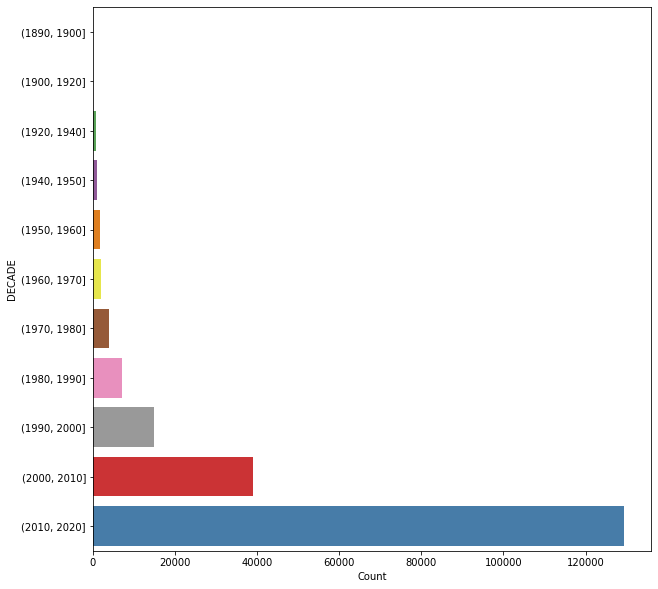

In [228]:
def movies_by_decade(df: pd.DataFrame) -> sns.countplot:
    '''
    Returns a plot of the number of movies by year
    '''
    df['MOVIE_YEAR'] = df['MOVIE_YEAR'].astype(int)
    df['DECADE'] = pd.cut(df['MOVIE_YEAR'], 
                          bins=[1890, 1900, 1920, 1940, 1950, 1960, 
                                1970, 1980, 1990, 2000, 2010, 2020])
    plt.figure(figsize=(10,10), facecolor='white')
    sns.countplot(y='DECADE', data=df, palette='Set1')
    plt.xlabel('Count')
    
movies_by_decade(movie_dq)

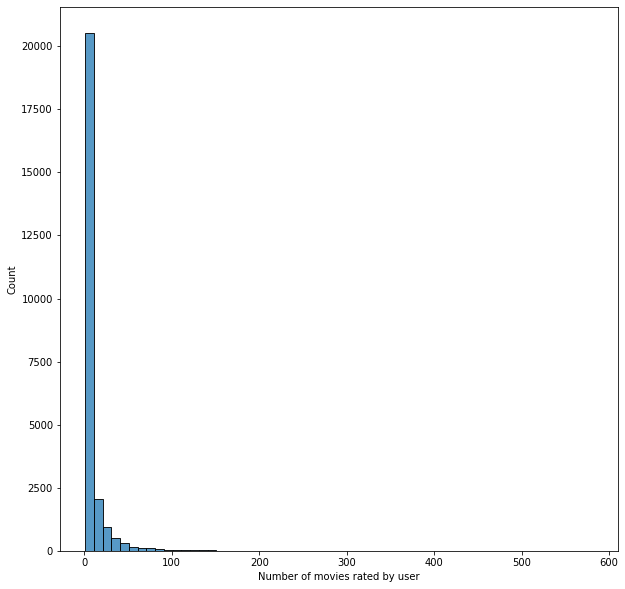

In [229]:
def number_of_ratings_by_user (df: pd.DataFrame) -> sns.countplot:
    ''' 
    Returns a histogram of the number of movies rated by each user
    '''
    count = movie_dq.groupby('USER_ID')['USER_ID'].count()
    plt.figure(figsize=(10,10), facecolor='white')
    sns.histplot(count, binwidth=10)
    plt.xlabel('Number of movies rated by user')
    
number_of_ratings_by_user(movie_dq)

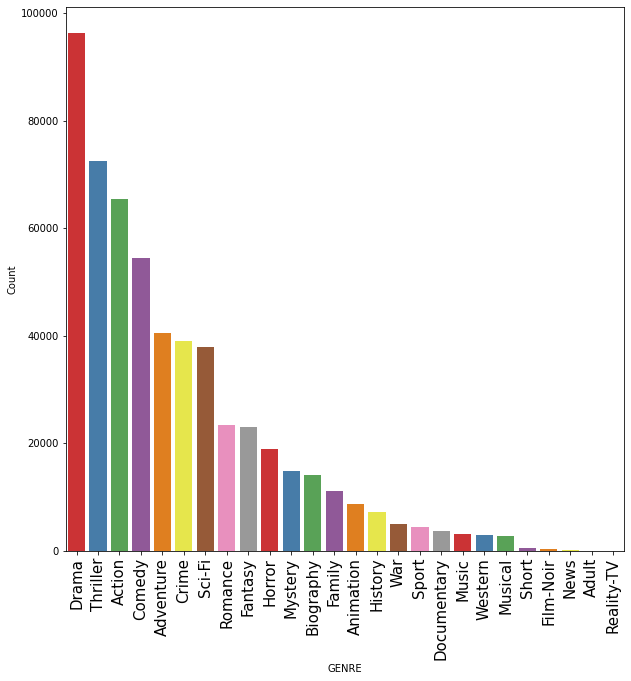

In [230]:
def movies_by_genre(df: pd.DataFrame) -> sns.barplot:
    '''
    Returns a plot of the number of movies by genre
    '''
    data = df.drop(columns=['USER_ID', 'MOVIE_ID', 'MOVIE_TITLE', 'RATING', 
                            'RATING_TIMESTAMP', 'TWITTER_ID', 'MOVIE_YEAR', 'DECADE'])
    data = data.melt(var_name='GENRE')
    data = data.groupby('GENRE', as_index=False).sum('value').sort_values(by='value', ascending=False)
    plt.figure(figsize=(10,10), facecolor='white')
    sns.barplot(x='GENRE', y='value', data=data, palette='Set1')
    plt.xticks(rotation=90, fontsize=15)
    plt.ylabel('Count')
    
movies_by_genre(movie_dq)

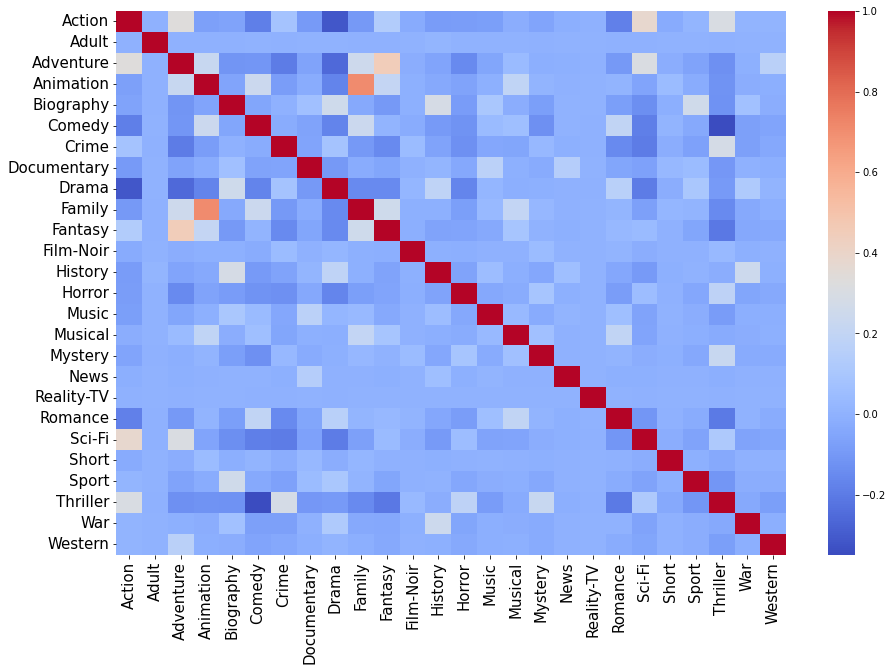

In [231]:
def genre_correlations(df: pd.DataFrame) -> sns.heatmap:
    '''
    Returns a heatmap of the correlations between movies with multiple genres
    '''
    data = movie_dq.drop(columns=['USER_ID', 'MOVIE_ID', 'MOVIE_TITLE', 'RATING', 
                                  'RATING_TIMESTAMP', 'TWITTER_ID', 'MOVIE_YEAR', 'DECADE'])
    plt.figure(figsize=(15,10), facecolor='white')
    sns.heatmap(data.corr(), cmap='coolwarm')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
genre_correlations(movie_dq)

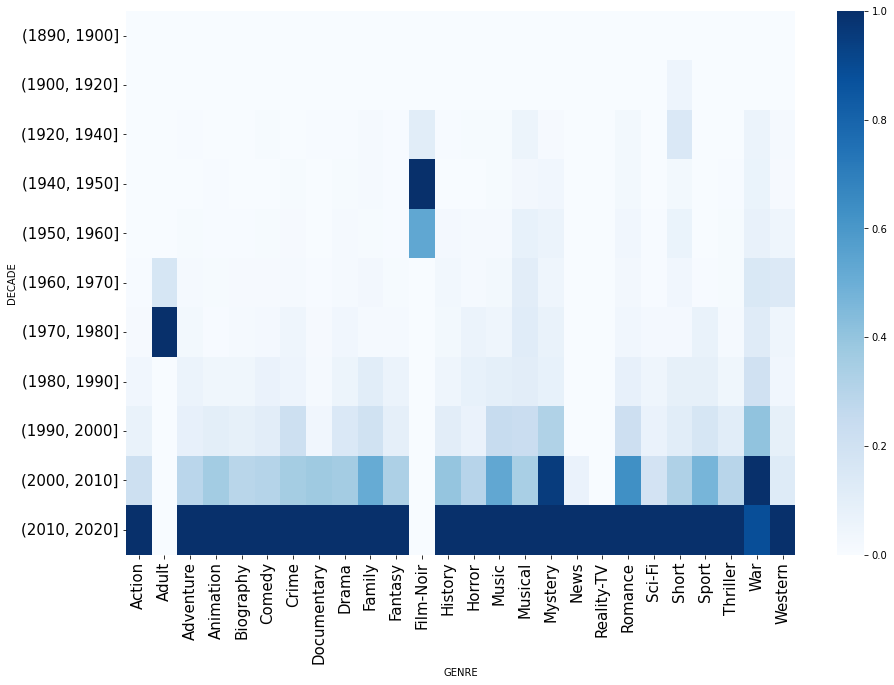

In [232]:
def genre_by_decade(df: pd.DataFrame) -> sns.heatmap:
    data = movie_dq.drop(columns=['USER_ID', 'MOVIE_ID', 'MOVIE_TITLE', 'RATING', 'RATING_TIMESTAMP', 'TWITTER_ID', 'MOVIE_YEAR'])
    data = data.melt(id_vars='DECADE', var_name='GENRE')
    data = data.groupby(['DECADE', 'GENRE'], as_index=False).sum('value')
    data = data.pivot('DECADE','GENRE','value')
    data_norm = (data - data.min()) / (data.max() - data.min())
    plt.figure(figsize=(15,10), facecolor='white')
    sns.heatmap(data_norm, cmap='Blues')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

genre_by_decade(movie_dq)